# Generate tedana walkthrough figures

In [1]:
import os
from glob import glob

import matplotlib.pyplot as plt
import nibabel as nib
import nitransforms as nit
import numpy as np
import pandas as pd
import seaborn as sns
from myst_nb import glue
from nilearn import image, masking, plotting
from repo2data.repo2data import Repo2Data

from tedana.io import load_data, new_nii_like
from tedana.utils import make_adaptive_mask
from nilearn.masking import compute_epi_mask

# Install the data if running locally, or point to cached data if running on neurolibre
DATA_REQ_FILE = os.path.join("../binder/data_requirement.json")

# Download data
repo2data = Repo2Data(DATA_REQ_FILE)
data_path = repo2data.install()
data_path = os.path.abspath(os.path.join(data_path[0], "data"))

ted_dir = os.path.join(data_path, "tedana")

/opt/hostedtoolcache/Python/3.7.12/x64/lib/python3.7/site-packages/nilearn/datasets/__init__.py:96: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  "Numpy arrays.", FutureWarning)
Module `duecredit` not successfully imported due to "No module named 'duecredit'". Package functionality unaffected.


---- repo2data starting ----
/opt/hostedtoolcache/Python/3.7.12/x64/lib/python3.7/site-packages/repo2data
Config from file :
../binder/data_requirement.json
Destination:
./../data/multi-echo-data-analysis

Info : ./../data/multi-echo-data-analysis already downloaded


## Load data

In [2]:
func_dir = os.path.join(data_path, "sub-04570/func/")
data_files = [
    os.path.join(func_dir, "sub-04570_task-rest_echo-1_space-scanner_desc-partialPreproc_bold.nii.gz"),
    os.path.join(func_dir, "sub-04570_task-rest_echo-2_space-scanner_desc-partialPreproc_bold.nii.gz"),
    os.path.join(func_dir, "sub-04570_task-rest_echo-3_space-scanner_desc-partialPreproc_bold.nii.gz"),
    os.path.join(func_dir, "sub-04570_task-rest_echo-4_space-scanner_desc-partialPreproc_bold.nii.gz"),
]
echo_times = np.array([12., 28., 44., 60.])

# Background anatomical image
xfm = os.path.join(func_dir, "sub-04570_task-rest_from-T1w_to-scanner_mode-image_xfm.txt")
xfm = nit.linear.load(xfm, fmt="itk")
t1_file = os.path.join(data_path, "sub-04570/anat/sub-04570_desc-preproc_T1w.nii.gz")
bg_img = xfm.apply(
    spatialimage=t1_file,
    reference=data_files[0],
)

# Tedana outputs
adaptive_mask_file = os.path.join(ted_dir, "sub-04570_task-rest_space-scanner_desc-adaptiveGoodSignal_mask.nii.gz")
mask = image.math_img("img >= 3", img=adaptive_mask_file)

# Optimally combined data
oc = masking.apply_mask(os.path.join(ted_dir, "sub-04570_task-rest_space-scanner_desc-optcom_bold.nii.gz"), mask)
oc_z = (oc - np.mean(oc, axis=0)) / np.std(oc, axis=0)

# Results from MEPCA
mepca_mmix = pd.read_table(
    os.path.join(ted_dir, "sub-04570_task-rest_space-scanner_desc-PCA_mixing.tsv"),
).values
oc_red = masking.apply_mask(
    os.path.join(ted_dir, "sub-04570_task-rest_space-scanner_desc-optcomPCAReduced_bold.nii.gz"),
    mask,
)

# Results from MEICA
meica_mmix = pd.read_table(
    os.path.join(ted_dir, "sub-04570_task-rest_space-scanner_desc-ICA_mixing.tsv"),
).values
norm_weights = masking.apply_mask(
    os.path.join(ted_dir, "sub-04570_task-rest_space-scanner_desc-ICAAveragingWeights_components.nii.gz"),
    mask,
)
meica_betas = np.dstack((
    masking.apply_mask(os.path.join(ted_dir, "sub-04570_task-rest_space-scanner_echo-1_desc-ICA_components.nii.gz"), mask).T,
    masking.apply_mask(os.path.join(ted_dir, "sub-04570_task-rest_space-scanner_echo-2_desc-ICA_components.nii.gz"), mask).T,
    masking.apply_mask(os.path.join(ted_dir, "sub-04570_task-rest_space-scanner_echo-3_desc-ICA_components.nii.gz"), mask).T,
    masking.apply_mask(os.path.join(ted_dir, "sub-04570_task-rest_space-scanner_echo-4_desc-ICA_components.nii.gz"), mask).T,
))
meica_betas = np.swapaxes(meica_betas, 1, 2)
r2_pred_betas = np.dstack((
    masking.apply_mask(
        os.path.join(ted_dir, "sub-04570_task-rest_space-scanner_echo-1_desc-ICAT2ModelPredictions_components.nii.gz"),
        mask,
    ).T,
    masking.apply_mask(
        os.path.join(ted_dir, "sub-04570_task-rest_space-scanner_echo-2_desc-ICAT2ModelPredictions_components.nii.gz"),
        mask,
    ).T,
    masking.apply_mask(
        os.path.join(ted_dir, "sub-04570_task-rest_space-scanner_echo-3_desc-ICAT2ModelPredictions_components.nii.gz"),
        mask,
    ).T,
    masking.apply_mask(
        os.path.join(ted_dir, "sub-04570_task-rest_space-scanner_echo-4_desc-ICAT2ModelPredictions_components.nii.gz"),
        mask,
    ).T,
))
r2_pred_betas = np.swapaxes(r2_pred_betas, 1, 2)
s0_pred_betas = np.dstack((
    masking.apply_mask(
        os.path.join(ted_dir, "sub-04570_task-rest_space-scanner_echo-1_desc-ICAS0ModelPredictions_components.nii.gz"),
        mask,
    ).T,
    masking.apply_mask(
        os.path.join(ted_dir, "sub-04570_task-rest_space-scanner_echo-2_desc-ICAS0ModelPredictions_components.nii.gz"),
        mask,
    ).T,
    masking.apply_mask(
        os.path.join(ted_dir, "sub-04570_task-rest_space-scanner_echo-3_desc-ICAS0ModelPredictions_components.nii.gz"),
        mask,
    ).T,
    masking.apply_mask(
        os.path.join(ted_dir, "sub-04570_task-rest_space-scanner_echo-4_desc-ICAS0ModelPredictions_components.nii.gz"),
        mask,
    ).T,
))
s0_pred_betas = np.swapaxes(s0_pred_betas, 1, 2)

# Component parameter estimates
betas_file = os.path.join(ted_dir, "sub-04570_task-rest_space-scanner_desc-ICA_components.nii.gz")
beta_maps = masking.apply_mask(betas_file, mask)

# Multi-echo denoised data
dn_data = masking.apply_mask(
    os.path.join(ted_dir, "sub-04570_task-rest_space-scanner_desc-optcomDenoised_bold.nii.gz"),
    mask,
)
hk_data = masking.apply_mask(
    os.path.join(ted_dir, "sub-04570_task-rest_space-scanner_desc-optcomAccepted_bold.nii.gz"),
    mask,
)

# Post-processed data
dn_t1c_data = masking.apply_mask(
    os.path.join(ted_dir, "sub-04570_task-rest_space-scanner_desc-optcomMIRDenoised_bold.nii.gz"),
    mask,
)
hk_t1c_data = masking.apply_mask(
    os.path.join(ted_dir, "sub-04570_task-rest_space-scanner_desc-optcomAccepted_bold.nii.gz"),
    mask,
)

# Component table
comp_tbl = pd.read_table(
    os.path.join(ted_dir, "sub-04570_task-rest_space-scanner_desc-tedana_metrics.tsv"),
    index_col="Component",
)

# Get voxel index for voxel most related to component with highest kappa value
acc_comp_tbl = comp_tbl.loc[comp_tbl["classification"] == "accepted"]
high_kappa_comp = acc_comp_tbl.sort_values(by="kappa", ascending=False).index.values[0]
high_kappa_comp_val = int(high_kappa_comp.split("_")[1])
voxel_idx = np.where(beta_maps[high_kappa_comp_val, :] == np.max(beta_maps[high_kappa_comp_val, :]))[0][0]

rej_comp_tbl = comp_tbl.loc[comp_tbl["classification"] == "rejected"]
low_kappa_comp = rej_comp_tbl.sort_values(by="rho", ascending=False).index.values[0]

# load data
data = [masking.apply_mask(f, mask) for f in data_files]
ts = [d[:, voxel_idx] for d in data]
ts_1d = np.hstack(ts)

n_echoes = len(echo_times)
n_trs = data[0].shape[0]

pal = sns.color_palette("cubehelix", n_echoes)

In [3]:
# Prepare data for model
log_data = np.log(np.abs(ts_1d) + 1)
# log_data = np.log(ts_1d)  # in a perfect world...
x = np.column_stack([np.ones(n_echoes), -1 * echo_times])
X = np.repeat(x, n_trs, axis=0)  # T * E

# Model fit
betas = np.linalg.lstsq(X, log_data, rcond=None)[0]
s0 = np.exp(betas[0])
r2s = betas[1]
t2s = 1. / r2s

# Values for plots
# Values from log-linear model
log_x = np.arange(-1000, 0, .01)
log_y = betas[0] + log_x*betas[1]

# Values from monoexponential decay model
mono_x = np.arange(0, 1000, .01)
mono_y = np.exp(-1*betas[1]*mono_x) * s0

# Get weights for optimal combination
alpha = echo_times * np.exp(-echo_times / t2s)
alpha = alpha / np.sum(alpha)  # unnecessary but good for bar plot below

# Combine data across echoes
oc_manual = np.average(np.vstack(ts), axis=0, weights=alpha)

### Echo-specific timeseries

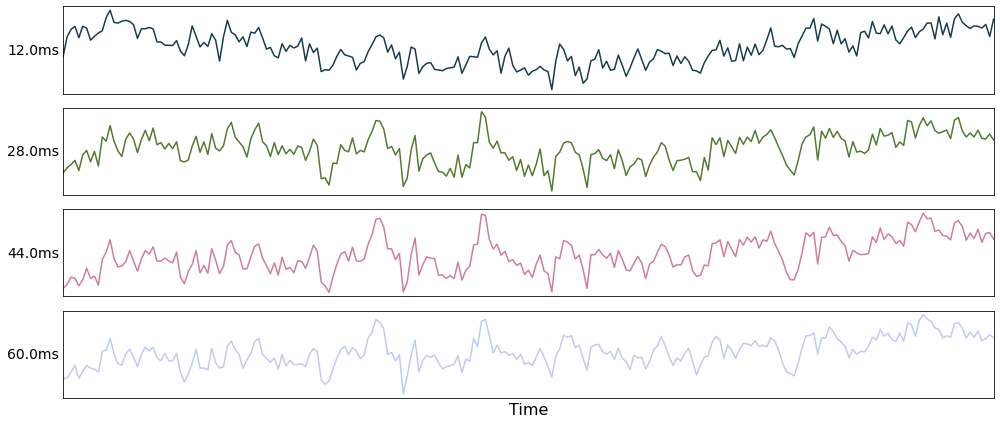

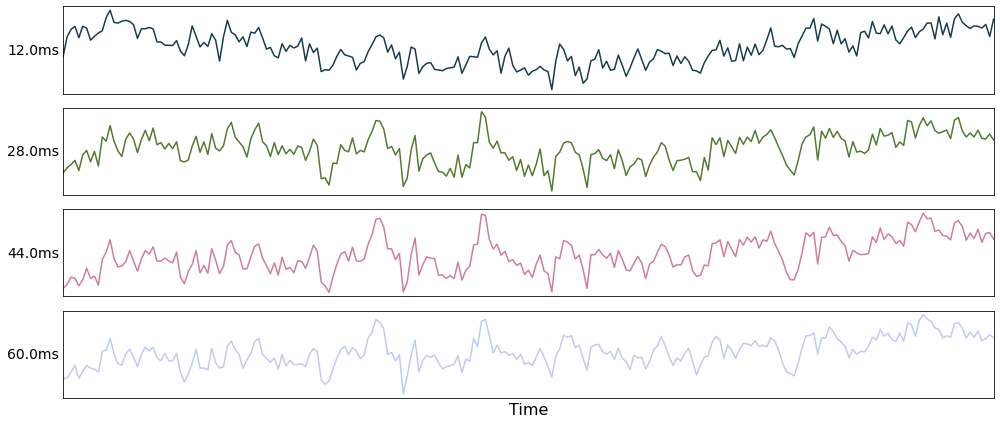

In [4]:
fig, axes = plt.subplots(n_echoes, sharex=True, sharey=False, figsize=(14, 6))
for i_echo in range(n_echoes):
    axes[i_echo].plot(ts[i_echo], color=pal[i_echo])
    axes[i_echo].set_ylabel(f"{echo_times[i_echo]}ms", rotation=0, va="center", ha="right", fontsize=14)
    axes[i_echo].set_yticks([])
    axes[i_echo].set_xticks([])

axes[-1].set_xlabel("Time", fontsize=16)
axes[-1].set_xlim(0, len(ts[i_echo])-1)
fig.tight_layout()
glue("fig_echo_timeseries", fig, display=False)

```{glue:figure} fig_echo_timeseries
:name: fig_echo_timeseries
:align: center

Time series from a voxel for each echo.
```

### Echo-specific data and echo time

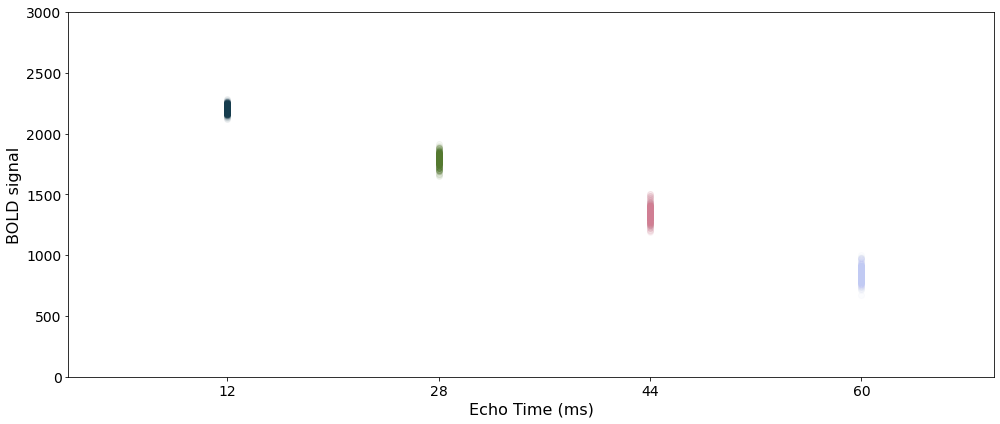

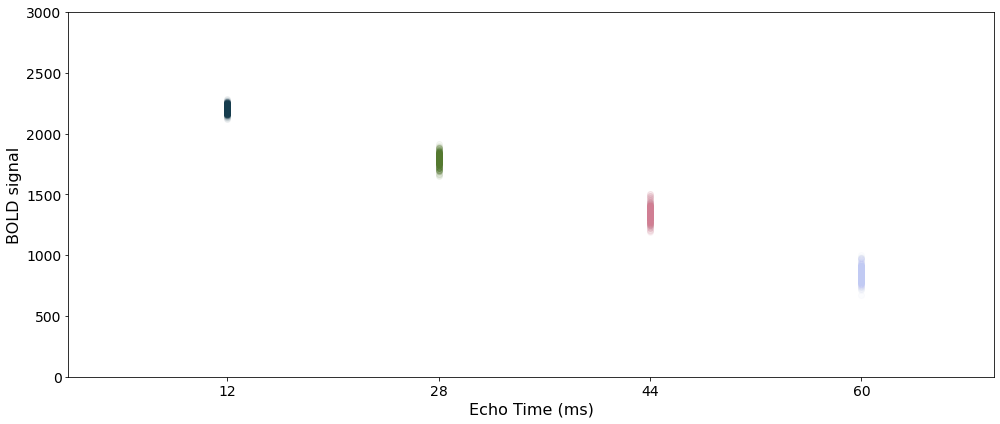

In [5]:
fig, ax = plt.subplots(figsize=(14, 6))
values = [i[0] for i in ts]
for i_echo in range(n_echoes):
    rep_echo_times = np.ones(n_trs) * echo_times[i_echo]
    ax.scatter(rep_echo_times, ts[i_echo], alpha=0.05, color=pal[i_echo])

ax.set_ylabel("BOLD signal", fontsize=16)
ax.set_xlabel("Echo Time (ms)", fontsize=16)
ax.set_xticks(echo_times)
ax.tick_params(axis="both", which="major", labelsize=14)
ax.set_xlim(0, 70)
ax.set_ylim(0, 3000)
fig.tight_layout()
glue("fig_echo_scatter", fig, display=False)

```{glue:figure} fig_echo_scatter
:name: fig_echo_scatter
:align: center

Scatter plot of voxel's values by echo time.
```

### Adaptive mask
Longer echo times are more susceptible to signal dropout, which means that certain brain regions
(e.g., orbitofrontal cortex, temporal poles) will only have good signal for some echoes.
In order to avoid using bad signal from affected echoes in calculating $T_{2}^*$ and $S_{0}$ for a given voxel,
`tedana` generates an adaptive mask, where the value for each voxel is the number of echoes with "good" signal.
When $T_{2}^*$ and $S_{0}$ are calculated below, each voxel's values are only calculated from the first $n$ echoes,
where $n$ is the value for that voxel in the adaptive mask.

/opt/hostedtoolcache/Python/3.7.12/x64/lib/python3.7/site-packages/nilearn/image/resampling.py:531: UserWarning: Casting data from int32 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))


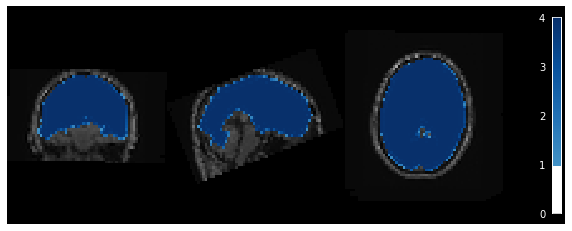

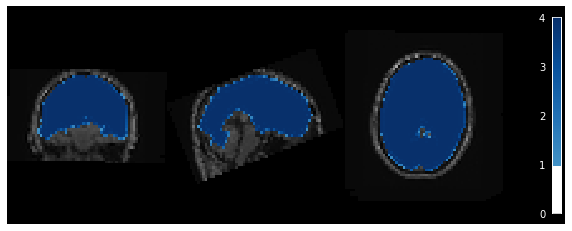

In [6]:
mask_img = compute_epi_mask(data_files[0])
data, img = load_data(data_files, len(echo_times))
mask, adaptive_mask = make_adaptive_mask(data, mask=mask_img, getsum=True)

adaptive_mask_img = new_nii_like(img, adaptive_mask)

fig, ax = plt.subplots(figsize=(10, 4))
palette = sns.color_palette("BuGn_r", 10)
plotting.plot_stat_map(
    adaptive_mask_img,
    vmax=n_echoes,
    # alpha=0.5,
    threshold=1.,
    draw_cross=False,
    colorbar=True,
    cmap="Blues",
    annotate=False,
    bg_img=bg_img,
    figure=fig,
    axes=ax,
)
glue("fig_adaptive_mask", fig, display=False)

```{glue:figure} fig_adaptive_mask
:name: fig_adaptive_mask
:align: center

Adaptive mask.
```

### Log-linear transformation

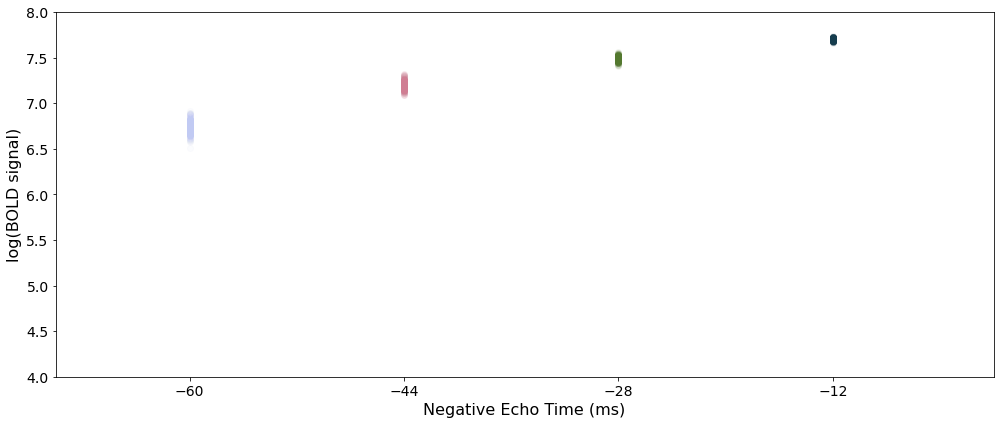

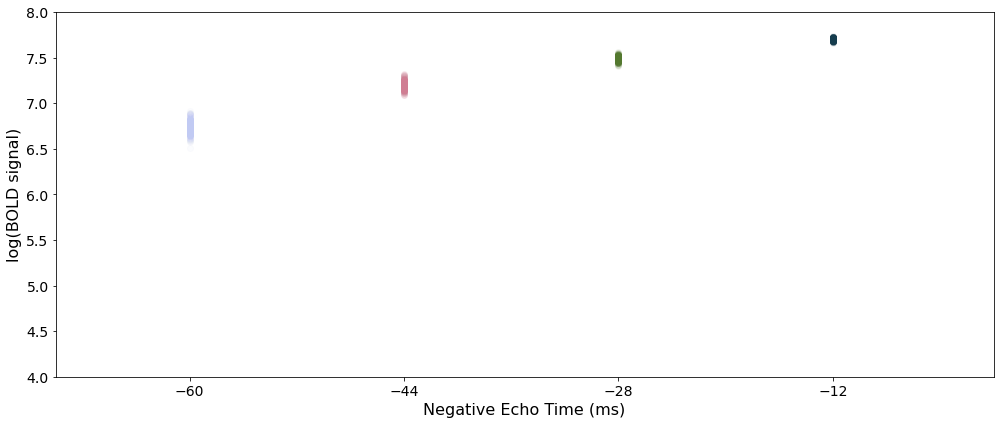

In [7]:
fig, ax = plt.subplots(figsize=(14, 6))
for i_echo in range(n_echoes):
    rep_echo_times = -1 * np.ones(n_trs) * echo_times[i_echo]
    log_echo_data = np.log((np.abs(ts[i_echo]) + 1))
    ax.scatter(rep_echo_times, log_echo_data, alpha=0.05, color=pal[i_echo])

ax.set_ylabel("log(BOLD signal)", fontsize=16)
ax.set_xlabel("Negative Echo Time (ms)", fontsize=16)
ax.set_xticks(-1 * echo_times)
ax.set_xlim(-70, 0)
ax.set_ylim(4, 8)
ax.tick_params(axis="both", which="major", labelsize=14)

fig.tight_layout()
glue("fig_loglin_scatter", fig, display=False)

```{glue:figure} fig_loglin_scatter
:name: fig_loglin_scatter
:align: center

Scatter plot of voxel's signal for each echo, after log-linear transformation.
```

### Log-linear model
Let $S$ be the BOLD signal for a given echo.

Let $TE$ be the echo time in milliseconds.

```{math}
:label: log_linear_model
\log_{e}(\left|\begin{pmatrix}
S(TE_{1}) \\
S(TE_{2}) \\
\vdots \\
S(TE_{n})\end{pmatrix}\right|
+
\begin{pmatrix}
1 \\
1 \\
\vdots \\
1\end{pmatrix}
) = B_{1}
\begin{pmatrix}
-TE_{1} \\
-TE_{2} \\
\vdots \\
-TE_{n}\end{pmatrix} +
\begin{pmatrix}
B_{0} \\
B_{0} \\
\vdots \\
B_{0}\end{pmatrix}
```

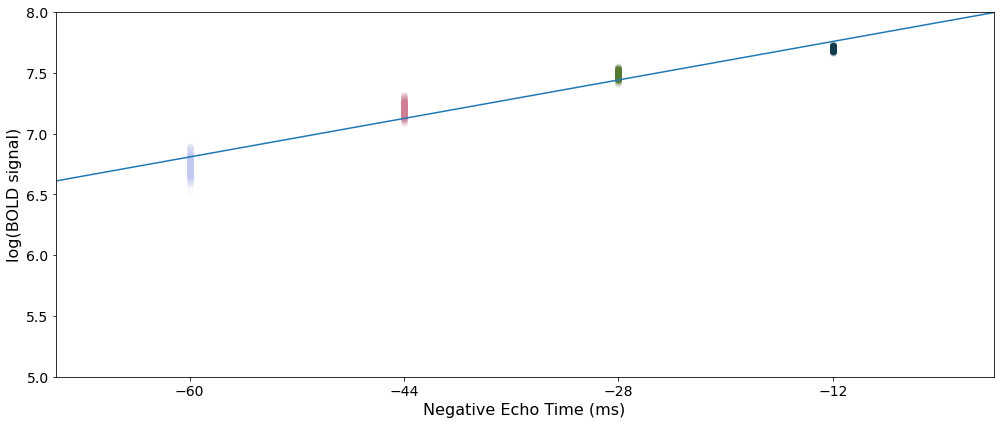

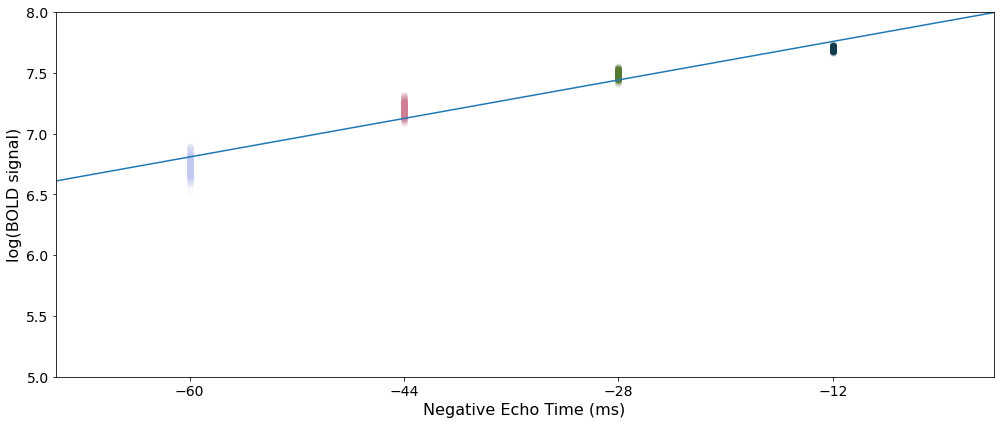

In [8]:
fig, ax = plt.subplots(figsize=(14, 6))
for i_echo in range(n_echoes):
    rep_echo_times = -1 * np.ones(n_trs) * echo_times[i_echo]
    log_echo_data = np.log((np.abs(ts[i_echo]) + 1))
    ax.scatter(rep_echo_times, log_echo_data, alpha=0.05, color=pal[i_echo])

ax.plot(log_x, log_y)

ax.set_ylabel("log(BOLD signal)", fontsize=16)
ax.set_xlabel("Negative Echo Time (ms)", fontsize=16)
ax.set_xticks(-1 * echo_times)
ax.set_xlim(-70, 0)
ax.set_ylim(5, 8)
ax.tick_params(axis="both", which="major", labelsize=14)

ax.annotate(
    "$B_0$: {0:.02f}\n$B_1$: {1:.02f}".format(betas[0], betas[1]),
    xy=(-70, 9.5),
    fontsize=16,
    bbox=dict(fc="white", ec="black", lw=1),
)

fig.tight_layout()
glue("fig_loglin_scatter_with_line", fig, display=False)

```{glue:figure} fig_loglin_scatter_with_line
:name: fig_loglin_scatter_with_line
:align: center

Scatter plot of voxel's signal for each echo, after log-linear transformation, with fitted line.
```

## Monoexponential decay model
Calculation of $S_{0}$ and $T_{2}^{*}$

```{math}
:label: monoexponential_decay_s0
S_{0} = e^{B_{0}}
```

```{math}
:label: monoexponential_decay_t2s
T_{2}^{*} = \frac{1}{B_{1}}
```

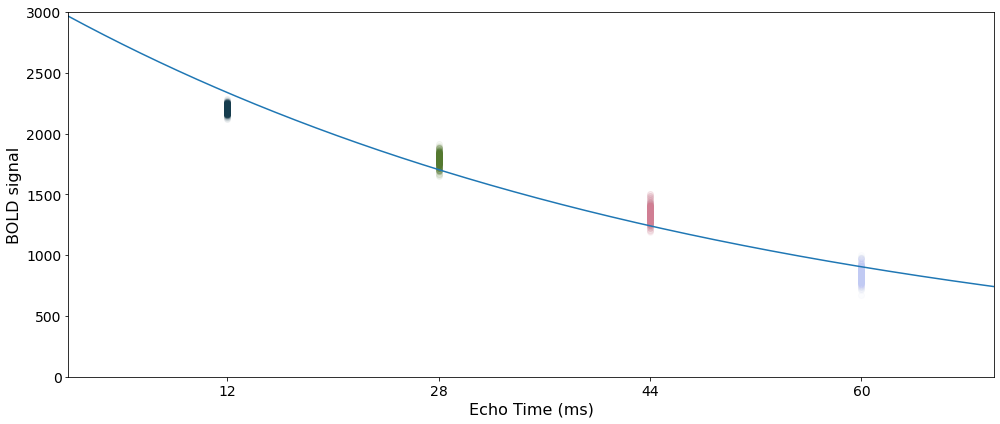

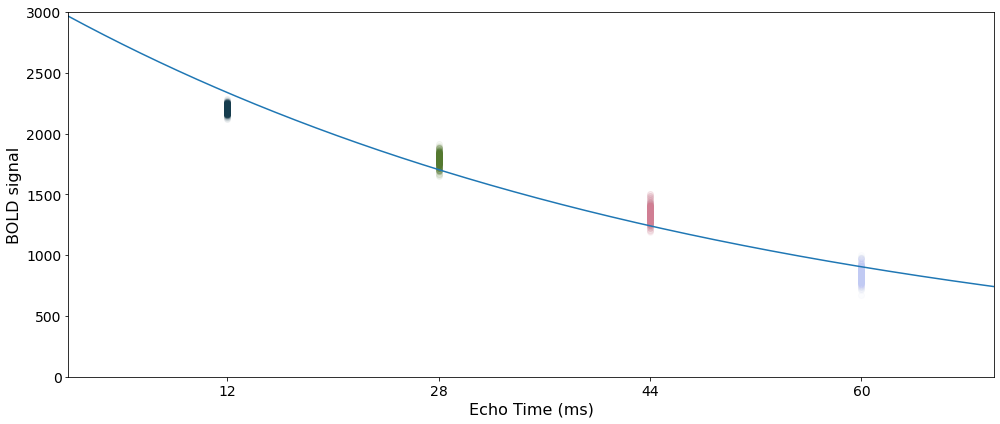

In [9]:
fig, ax = plt.subplots(figsize=(14, 6))
for i_echo in range(n_echoes):
    rep_echo_times = np.ones(n_trs) * echo_times[i_echo]
    ax.scatter(rep_echo_times, ts[i_echo], alpha=0.05, color=pal[i_echo])

ax.plot(mono_x, mono_y)

ax.set_ylabel("BOLD signal", fontsize=16)
ax.set_xlabel("Echo Time (ms)", fontsize=16)
ax.set_xticks(echo_times)
ax.set_xlim(0, 70)
ax.set_ylim(0, 3000)
ax.tick_params(axis="both", which="major", labelsize=14)
ax.annotate(
    "$S_0$: {0:.02f}\n$T_2^*$: {1:.02f}".format(s0, t2s),
    xy=(86.5, 13500),
    fontsize=16,
    bbox=dict(fc="white", ec="black", lw=1),
)

fig.tight_layout()
glue("fig_loglin_scatter_with_t2s", fig, display=False)

```{glue:figure} fig_loglin_scatter_with_t2s
:name: fig_loglin_scatter_with_t2s
:align: center

Scatter plot of voxel's signal for each echo, after log-linear transformation, with fitted line and T2* estimate.
```

### T2*

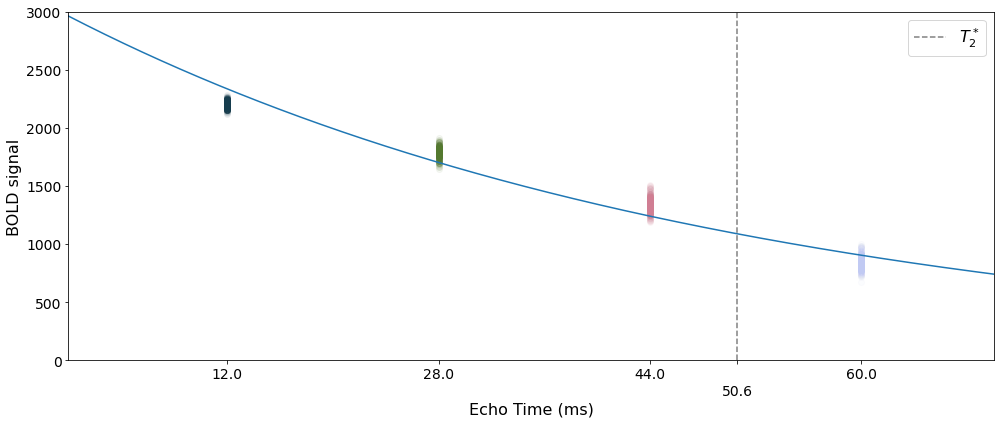

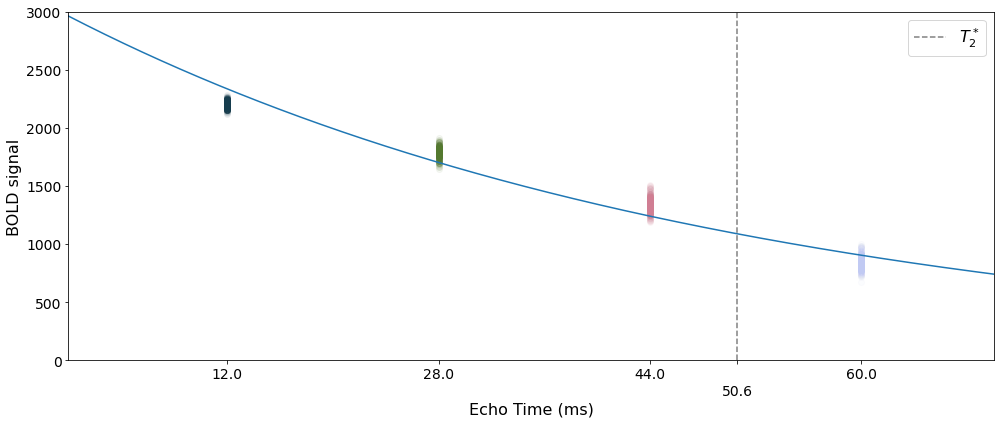

In [10]:
fig, ax = plt.subplots(figsize=(14, 6))
for i_echo in range(n_echoes):
    rep_echo_times = np.ones(n_trs) * echo_times[i_echo]
    ax.scatter(rep_echo_times, ts[i_echo], alpha=0.05, color=pal[i_echo])

ax.plot(mono_x, mono_y)

ax.axvline(t2s, 0, 1, label="$T_2^*$", color="black", linestyle="--", alpha=0.5)
ax.set_ylabel("BOLD signal", fontsize=16)
ax.set_xlabel("Echo Time (ms)", fontsize=16)
ax.set_xticks(np.hstack((echo_times, [np.round(t2s, 1)])))
ax.set_xlim(0, 70)
ax.set_ylim(0, 3000)
ax.tick_params(axis="both", which="major", labelsize=14)
ax.xaxis.get_major_ticks()[-1].set_pad(20)

legend = ax.legend(frameon=True, fontsize=16)

fig.tight_layout()
glue("fig_scatter_with_t2s", fig, display=False)

```{glue:figure} fig_scatter_with_t2s
:name: fig_scatter_with_t2s
:align: center

Scatter plot of voxel's signal for each echo with T2* estimate.
```
### Optimal combination weights

/opt/hostedtoolcache/Python/3.7.12/x64/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


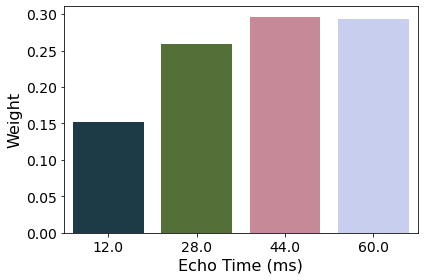

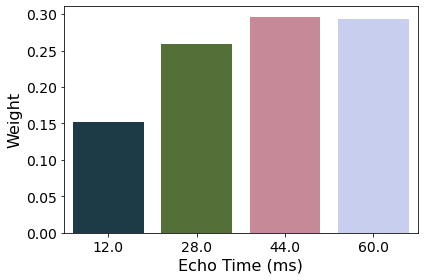

In [11]:
fig, ax = plt.subplots()
sns.barplot(echo_times, alpha, ax=ax, palette=pal)
ax.set_ylabel("Weight", fontsize=16)
ax.set_xlabel("Echo Time (ms)", fontsize=16)
ax.tick_params(axis="both", which="major", labelsize=14)
fig.tight_layout()
glue("fig_optcom_weights", fig, display=False)

```{glue:figure} fig_optcom_weights
:name: fig_optcom_weights
:align: center

Averaging weights for optimal combination.
```

### Optimally combined timeseries

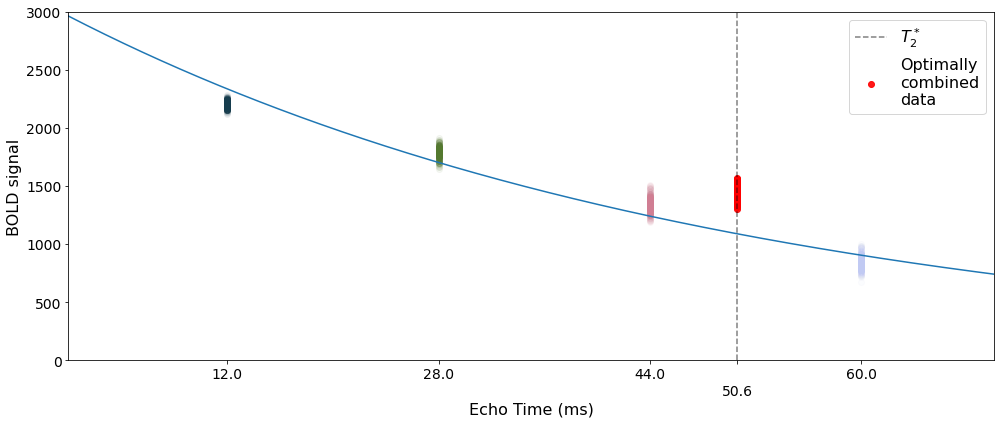

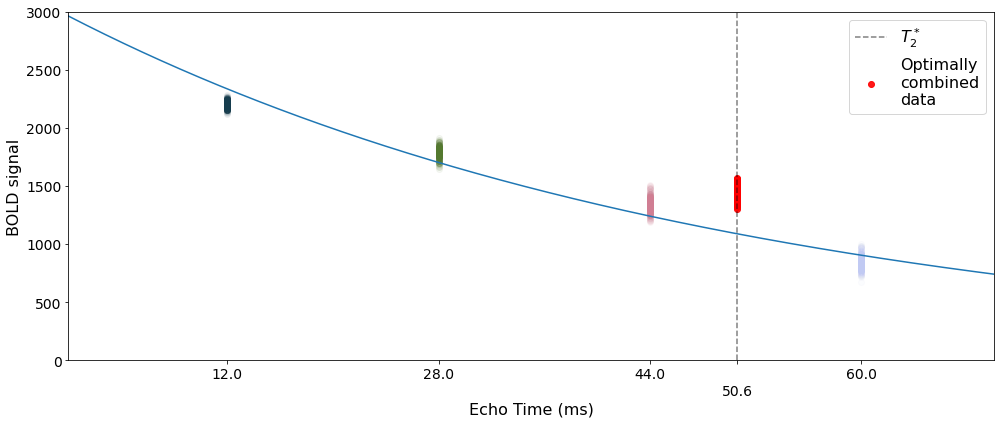

In [12]:
fig, ax = plt.subplots(figsize=(14, 6))
for i_echo in range(n_echoes):
    rep_echo_times = np.ones(n_trs) * echo_times[i_echo]
    ax.scatter(rep_echo_times, ts[i_echo], alpha=0.05, color=pal[i_echo])

ax.plot(mono_x, mono_y)

# Optimal combination
rep_t2s = np.ones(n_trs) * t2s
ax.scatter(rep_t2s, oc_manual, alpha=0.9, color="red", label="Optimally\ncombined\ndata")

ax.axvline(t2s, 0, 20000, label="$T_2^*$", color="black", linestyle="--", alpha=0.5)
ax.set_ylabel("BOLD signal", fontsize=16)
ax.set_xlabel("Echo Time (ms)", fontsize=16)
ax.set_xticks(np.hstack((echo_times, [np.round(t2s, 1)])))
ax.set_xlim(0, 70)
ax.set_ylim(0, 3000)
ax.tick_params(axis="both", which="major", labelsize=14)
ax.xaxis.get_major_ticks()[-1].set_pad(20)

legend = ax.legend(frameon=True, fontsize=16)

fig.tight_layout()
glue("fig_scatter_with_optcom", fig, display=False)

```{glue:figure} fig_scatter_with_optcom
:name: fig_scatter_with_optcom
:align: center

Scatter plot of voxel's signal for each echo with optimally combined signal as well.
```

### Optimally combined timeseries

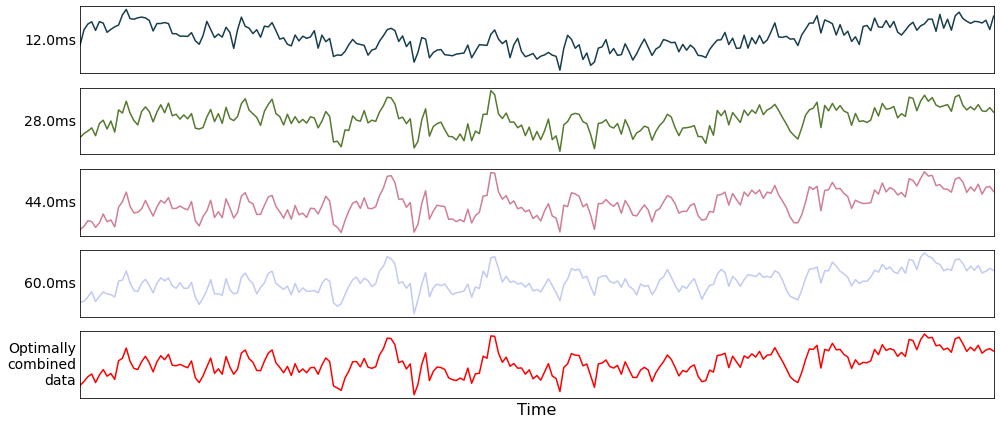

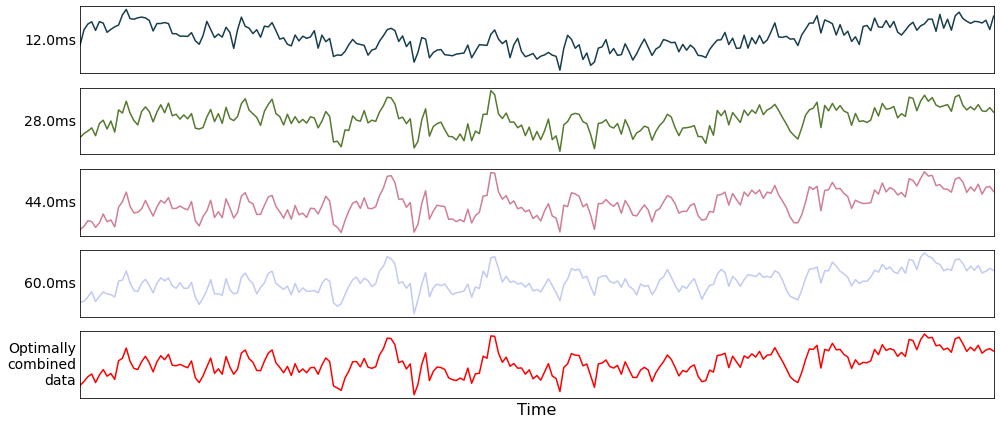

In [13]:
fig, axes = plt.subplots(n_echoes+1, sharex=True, sharey=False, figsize=(14, 6))
for i_echo in range(n_echoes):
    axes[i_echo].plot(ts[i_echo], color=pal[i_echo])
    axes[i_echo].set_ylabel(f"{echo_times[i_echo]}ms", rotation=0, va="center", ha="right", fontsize=14)
    axes[i_echo].set_yticks([])
    axes[i_echo].set_xticks([])

axes[-1].plot(oc_manual, color="red")
axes[-1].set_ylabel("Optimally\ncombined\ndata", rotation=0, va="center", ha="right", fontsize=14)
axes[-1].set_xlabel("Time", fontsize=16)
axes[-1].set_yticks([])
axes[-1].set_xticks([])
axes[-1].set_xlim(0, len(ts[i_echo])-1)
ax.tick_params(axis="both", which="major", labelsize=14)
fig.tight_layout()
glue("fig_echo_timeseries_with_optcom", fig, display=False)

```{glue:figure} fig_echo_timeseries_with_optcom
:name: fig_echo_timeseries_with_optcom
:align: center

Echo-wise time series for a voxel, including the optimally combined time series.
```

### Multi-Echo Principal Components Analysis
Optimally combined data are decomposed with PCA.
The PCA components are selected according to one of multiple possible approaches.
Two possible approaches are a decision tree and a threshold using the percentage of variance explained by each component.

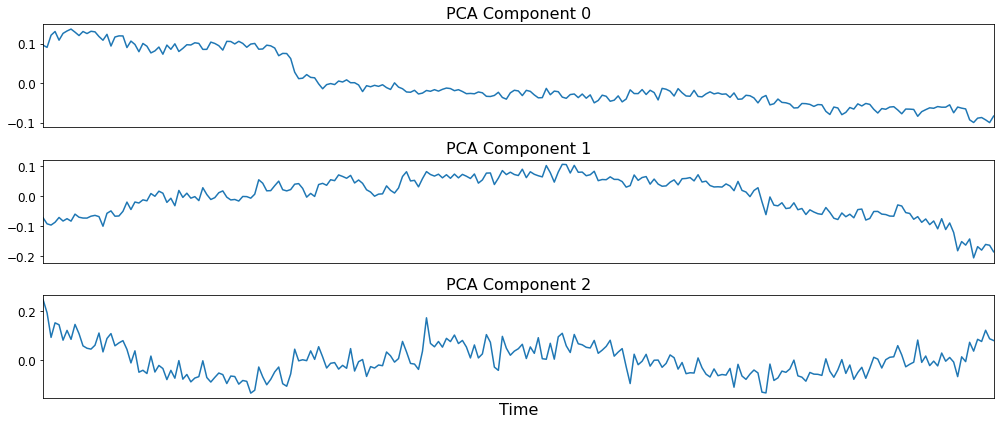

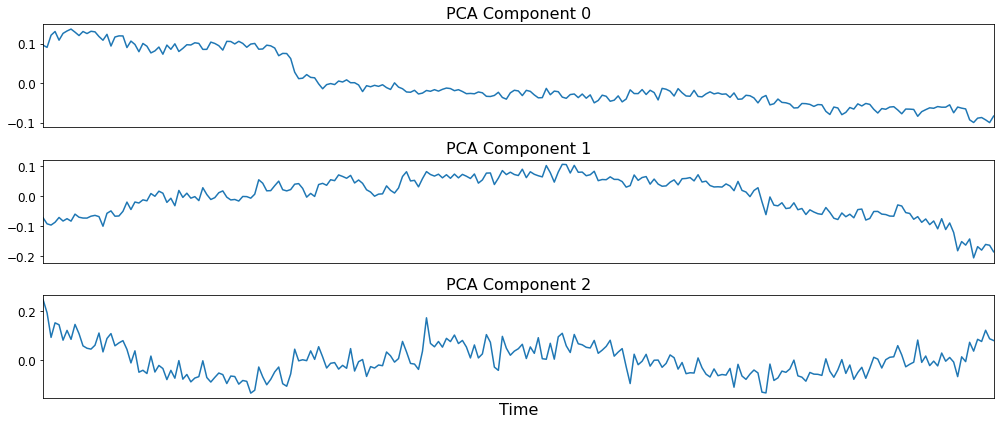

In [14]:
fig, axes = plt.subplots(3, sharex=True, figsize=(14, 6))
axes[-1].set_xlim(0, mepca_mmix.shape[0]-1)
axes[-1].set_xticks([])
axes[-1].set_xlabel("Time", fontsize=16)

for comp_to_plot in [0, 1, 2]:
    axes[comp_to_plot].plot(mepca_mmix[:, comp_to_plot])
    axes[comp_to_plot].set_title(f"PCA Component {comp_to_plot}", fontsize=16)
    axes[comp_to_plot].tick_params(axis="both", which="major", labelsize=12)

fig.tight_layout()
glue("fig_pca_timeseries", fig, display=False)

```{glue:figure} fig_pca_timeseries
:name: fig_pca_timeseries
:align: center

Time series of three PCA components.
```

## Data Whitening
The selected components from the PCA are recombined to produce a whitened version of the optimally combined data.

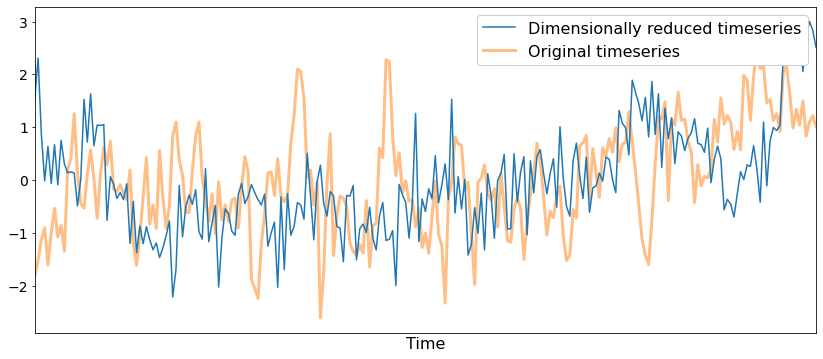

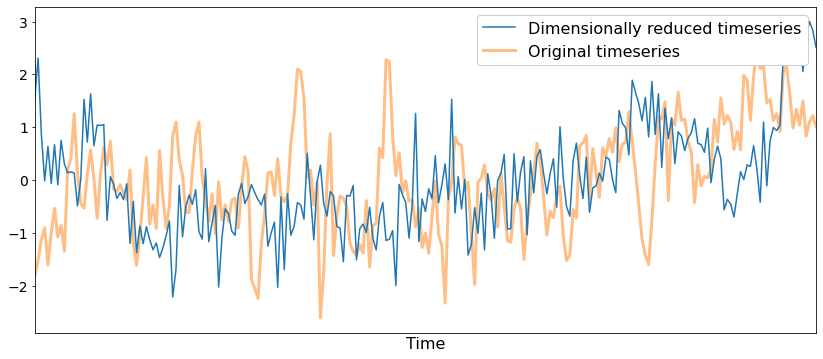

In [15]:
fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(oc_red[:, voxel_idx], label="Dimensionally reduced timeseries", zorder=1.)
ax.plot(oc_z[:, voxel_idx], label="Original timeseries", alpha=0.5, zorder=0., linewidth=3)
legend = ax.legend(frameon=True, fontsize=16, loc="upper right", framealpha=1)
ax.set_xlim(0, oc_z.shape[0]-1)
ax.set_xticks([])
ax.set_xlabel("Time", fontsize=16)
ax.tick_params(axis="both", which="major", labelsize=14)
glue("fig_optcom_reduced_timeseries", fig, display=False)

```{glue:figure} fig_optcom_reduced_timeseries
:name: fig_optcom_reduced_timeseries
:align: center

Time series of optimally combined data from a voxel, before and after dimensionality reduction with PCA.
```

### Multi-Echo Independent Components Analysis
The whitened optimally combined data are then decomposed with ICA.
The number of ICA components is limited to the number of retained components from the PCA,
in order to reflect the true dimensionality of the data.
ICA produces a mixing matrix (i.e., timeseries for each component).

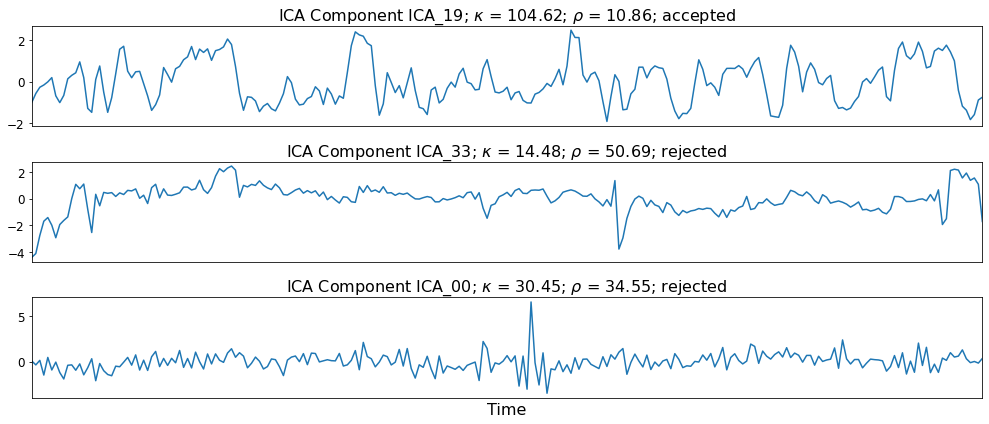

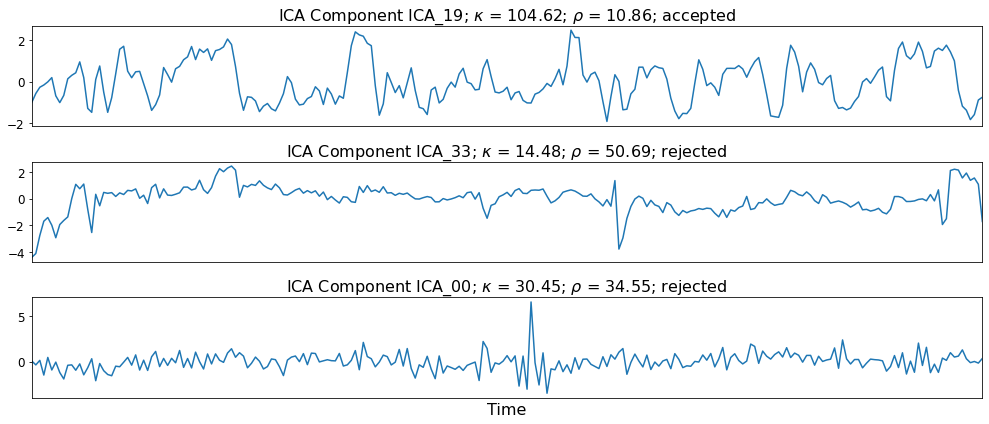

In [16]:
fig, axes = plt.subplots(3, sharex=True, figsize=(14, 6))

comps_to_plot = [high_kappa_comp, low_kappa_comp, "ICA_00"]

for i_comp, comp_to_plot in enumerate(comps_to_plot):
    idx = int(comp_to_plot.split("_")[1])
    k = comp_tbl.loc[comp_to_plot, "kappa"]
    r = comp_tbl.loc[comp_to_plot, "rho"]
    c = comp_tbl.loc[comp_to_plot, "classification"]
    axes[i_comp].plot(meica_mmix[:, idx])
    axes[i_comp].set_title(
        "ICA Component {0}; $\\kappa$ = {1:.02f}; $\\rho$ = {2:.02f}; {3}".format(comp_to_plot, k, r, c),
        fontsize=16,
    )

axes[0].set_xlim(0, meica_mmix.shape[0]-1)
axes[2].set_xticks([])
axes[2].set_xlabel("Time", fontsize=16)
axes[0].tick_params(axis="both", which="major", labelsize=12)
axes[1].tick_params(axis="both", which="major", labelsize=12)
axes[2].tick_params(axis="both", which="major", labelsize=12)
fig.tight_layout()
glue("fig_ica_timeseries", fig, display=False)

```{glue:figure} fig_ica_timeseries
:name: fig_ica_timeseries
:align: center

Time series of three ICA components.
```

## $R_2$ and $S_0$ Model Fit
Linear regression is used to fit the component timeseries to each voxel in each echo from the original, echo-specific data.
This results in echo- and voxel-specific betas for each of the components.
TE-dependence ($R_2$) and TE-independence ($S_0$) models can then be fit to these betas.

These models allow calculation of F-statistics for the $R_2$ and $S_0$ models (referred to as $\kappa$ and $\rho$, respectively).

Note that the values here are for a single voxel (the highest-weighted one for the component),
but $\kappa$ and $\rho$ are averaged across voxels.

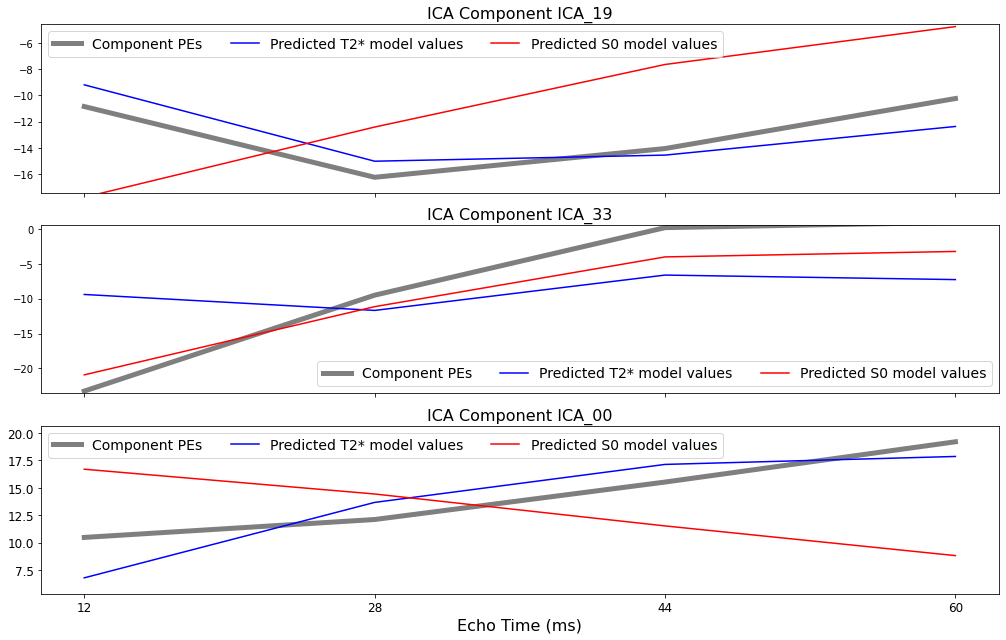

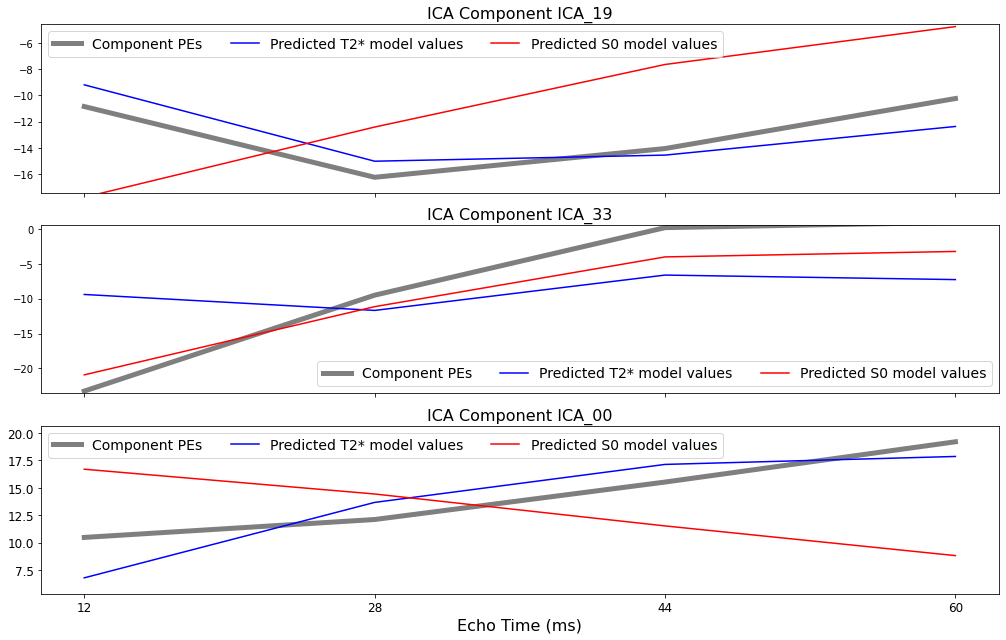

In [17]:
fig, axes = plt.subplots(3, sharex=True, figsize=(14, 9))
axes[-1].set_xticks(echo_times)
axes[-1].tick_params(axis="both", which="major", labelsize=12)
axes[-1].set_xlabel("Echo Time (ms)", fontsize=16)

for i_comp, comp in enumerate(comps_to_plot):  # only generate plots for a few components
    comp_voxel_idx = np.where(beta_maps[i_comp, :] == np.max(beta_maps[i_comp, :]))[0][0]
    # Use weight map to average as fitmodels_direct does
    comp_weights = meica_betas[comp_voxel_idx, :, i_comp]
    r2_pred_weights = r2_pred_betas[comp_voxel_idx, :, i_comp]
    s0_pred_weights = s0_pred_betas[comp_voxel_idx, :, i_comp]

    axes[i_comp].plot(echo_times, comp_weights, c="black", alpha=0.5, linewidth=5, label="Component PEs")
    axes[i_comp].plot(echo_times, r2_pred_weights, c="blue", label="Predicted T2* model values")
    axes[i_comp].plot(echo_times, s0_pred_weights, c="red", label="Predicted S0 model values")

    # Set yticklabels
    temp = np.hstack((comp_weights, s0_pred_weights, r2_pred_weights))
    lim = np.mean(temp) * .05
    axes[i_comp].set_ylim(np.floor(np.min(temp)) - lim, np.ceil(np.max(temp)) + lim)
    legend = axes[i_comp].legend(frameon=True, fontsize=14, ncol=3)
    axes[i_comp].set_title(f"ICA Component {comp}", fontsize=16)

fig.tight_layout()
glue("fig_ica_weights", fig, display=False)

```{glue:figure} fig_ica_weights
:name: fig_ica_weights
:align: center

Echo-wise model weights for three ICA components.
```

## ICA Component Selection and Multi-Echo Denoising
A decision tree is applied to $\kappa$, $\rho$, and other metrics in order to classify ICA components as TE-dependent (BOLD signal),
TE-independent (non-BOLD noise), or neither (to be ignored).

The ICA components are fitted to the original (not whitened) optimally combined data with linear regression,
which is used to weight the components for construction of the denoised data.
The residuals from this regression will thus include the variance that was not included in the PCA-whitened optimally combined data.

The {term}`MEDN` dataset is constructed from the accepted (BOLD) and ignored components, as well as the residual variance not explained by the ICA.
The {term}`MEHK` dataset is constructed just from the accepted (BOLD) components.
This means that ignored components and residual variance not explained by the ICA are not included in the resulting dataset.

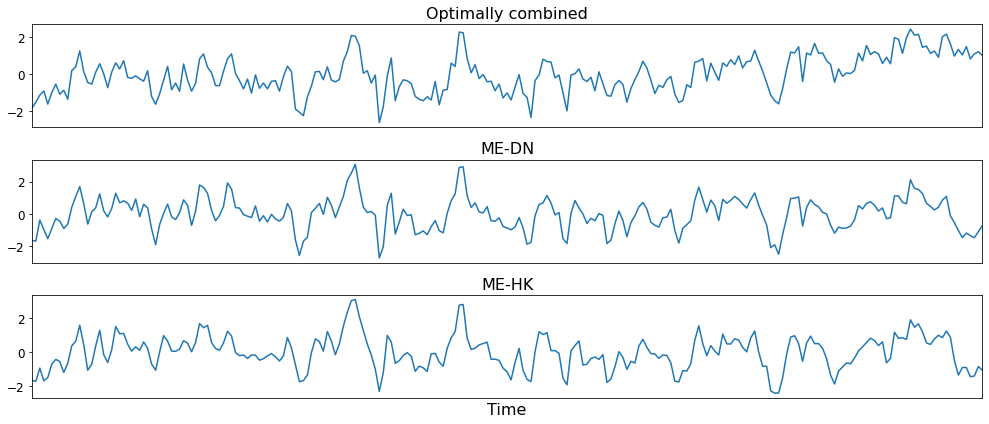

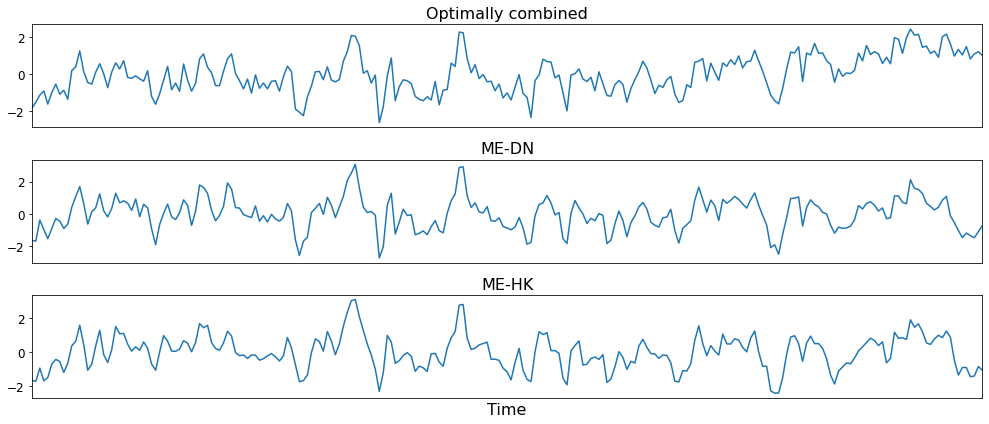

In [18]:
dn_data_z = (dn_data - np.mean(dn_data, axis=0)) / np.std(dn_data, axis=0)
hk_data_z = (hk_data - np.mean(hk_data, axis=0)) / np.std(hk_data, axis=0)

fig, axes = plt.subplots(3, sharex=True, figsize=(14, 6))
axes[0].plot(oc_z[:, voxel_idx], label="Optimally combined")
axes[0].set_title("Optimally combined", fontsize=16)

axes[1].plot(dn_data_z[:, voxel_idx], label="ME-DN")
axes[1].set_title("ME-DN", fontsize=16)

axes[2].plot(hk_data_z[:, voxel_idx])
axes[2].set_title("ME-HK", fontsize=16)
legend = ax.legend(frameon=True)
axes[0].set_xlim(0, oc_z.shape[0]-1)
axes[2].set_xticks([])
axes[2].set_xlabel("Time", fontsize=16)
axes[0].tick_params(axis="both", which="major", labelsize=12)
axes[1].tick_params(axis="both", which="major", labelsize=12)
axes[2].tick_params(axis="both", which="major", labelsize=12)
fig.tight_layout()

glue("fig_medn_timeseries", fig, display=False)

```{glue:figure} fig_medn_timeseries
:name: fig_medn_timeseries
:align: center

Time series for optimally combined, denoised, and high-kappa data for a single voxel.
```

## Post-processing to remove spatially diffuse noise
Due to the constraints of ICA, MEICA is able to identify and remove spatially localized noise components,
but it cannot identify components that are spread out throughout the whole brain.

One of several post-processing strategies may be applied to the ME-DN or ME-HK datasets in order to remove spatially diffuse
(ostensibly respiration-related) noise.
Methods which have been employed in the past include global signal regression (GSR), T1c-GSR, anatomical CompCor,
Go Decomposition (GODEC), and robust PCA.

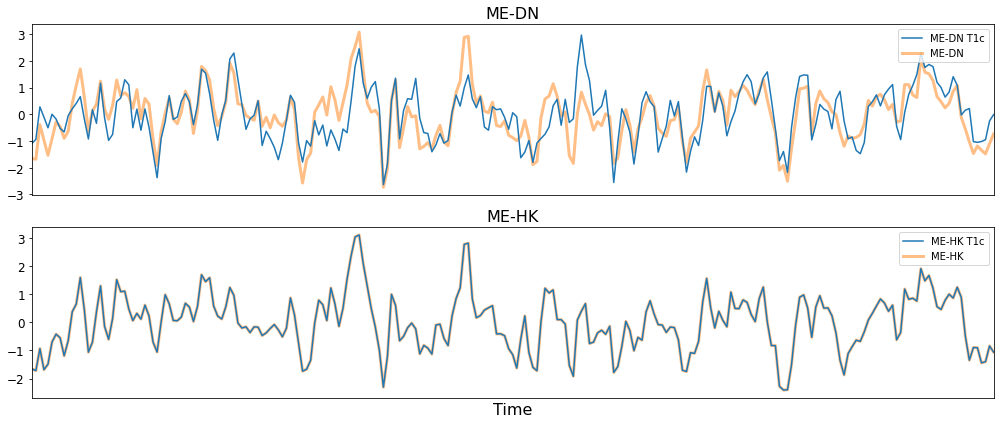

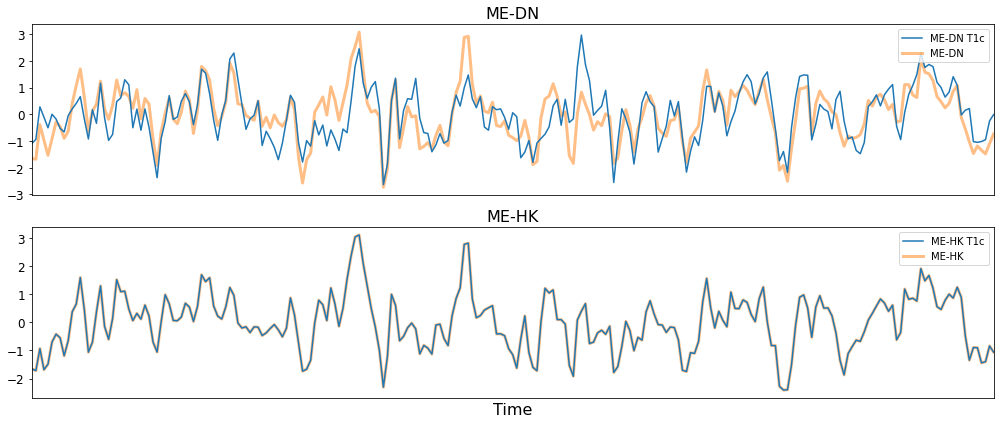

In [19]:
dn_t1c_data_z = (dn_t1c_data - np.mean(dn_t1c_data, axis=0)) / np.std(dn_t1c_data, axis=0)
hk_t1c_data_z = (hk_t1c_data - np.mean(hk_t1c_data, axis=0)) / np.std(hk_t1c_data, axis=0)

fig, axes = plt.subplots(2, sharex=True, figsize=(14, 6))
axes[0].plot(dn_t1c_data_z[:, voxel_idx], label="ME-DN T1c")
axes[0].plot(dn_data_z[:, voxel_idx], label="ME-DN", alpha=0.5, linewidth=3, zorder=0.)
axes[0].set_title("ME-DN", fontsize=16)
legend = axes[0].legend(frameon=True, loc="upper right")

axes[1].plot(hk_t1c_data_z[:, voxel_idx], label="ME-HK T1c")
axes[1].plot(hk_data_z[:, voxel_idx], label="ME-HK", alpha=0.5, linewidth=3, zorder=0.)
axes[1].set_title("ME-HK", fontsize=16)
legend = axes[1].legend(frameon=True)
axes[0].set_xlim(0, oc_z.shape[0]-1)
axes[1].set_xticks([])
axes[1].set_xlabel("Time", fontsize=16)
axes[0].tick_params(axis="both", which="major", labelsize=12)
axes[1].tick_params(axis="both", which="major", labelsize=12)
fig.tight_layout()
glue("fig_mir_timeseries", fig, display=False)

```{glue:figure} fig_mir_timeseries
:name: fig_mir_timeseries
:align: center

Time series from a voxel before and after minimum image regression.
```